# Source finding demo

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
#from astropy.table import QTable
from numba import njit
from photutils import segmentation as segm
from scipy.spatial import ConvexHull

## 2. Read data

### select one dataset:

In [2]:
dataset = 3

1D spectra

2D images:

In [3]:
if dataset == 1:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data[69]*1.  # to make sure it's converted to float
    #data = hdu[0].data[:, 270, :]*1.
    #data = hdu[0].data[:, 170, :]*1.
    #data = hdu[0].data[99]*1.

In [4]:
if dataset == 2:
    hdu = fits.open('data/CIG_335.fits')
    data = hdu[0].data[3000:4000, 1500:2500] * 1.  # to make sure it's converted to float

3D datacubes:

In [5]:
if dataset == 3:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data *1.  # to make sure it's converted to float


### visual inspection:

In [6]:
data_dimensionality = len(data.shape)

In [7]:
if data_dimensionality == 2:
    plt.close('data')
    fig = plt.figure('data')
    ax = fig.subplots()

    im = ax.imshow(data,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=np.nanpercentile(data, 5), vmax=np.nanpercentile(data, 95),
                  )
    ax.set_title('Input data')
    cb = fig.colorbar(im, ax=ax)

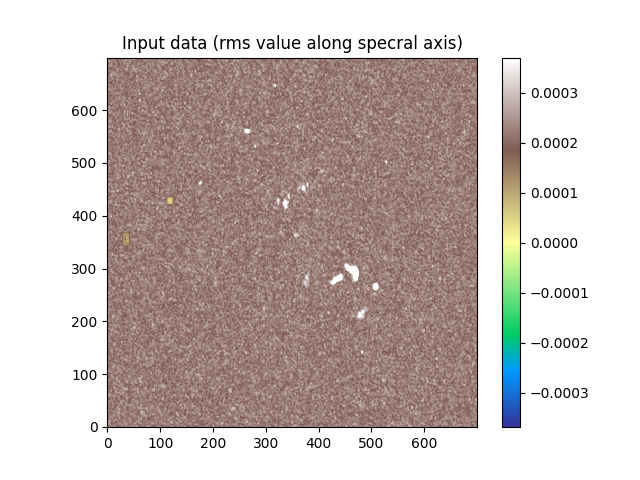

In [8]:
if data_dimensionality == 3:
    plt.close('data')
    fig = plt.figure('data')
    ax = fig.subplots()

    im = ax.imshow(np.sqrt(np.nanmean(data**2, axis=0)),
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=np.nanpercentile(data, 5), vmax=np.nanpercentile(data, 95),
                  )
    ax.set_title('Input data (rms value along specral axis)')
    cb = fig.colorbar(im, ax=ax)

## 3. Find mode

### cumulative mass:

In [9]:
sorted_by_data = np.argsort(data.flatten())
sorted_data = data.flatten()[sorted_by_data]

Allow for statistical weights:

In [10]:
weights = np.ones_like(data, dtype=np.float64)
sorted_weight = weights.flatten()[sorted_by_data]

In [11]:
cumulative_mass = np.nancumsum(sorted_weight)
sorted_weight /= cumulative_mass[-1]
cumulative_mass /= cumulative_mass[-1]

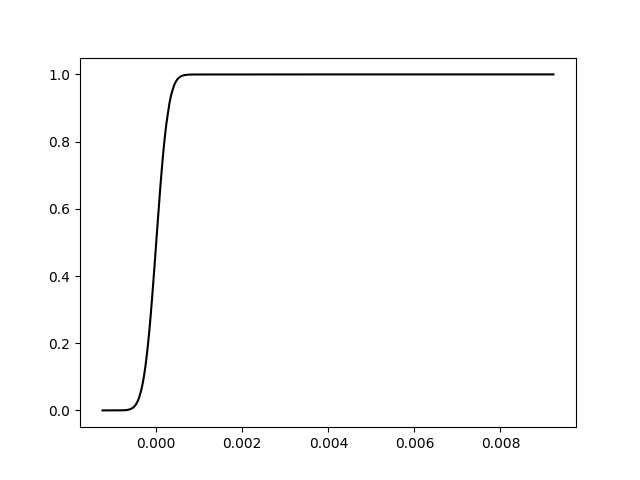

In [12]:
plt.close('cumulative_mass')
fig = plt.figure('cumulative_mass')
ax = fig.subplots()

ax.plot(sorted_data, cumulative_mass, 'k-')

### density peak (mode of the probability distribution):
Here we have a couple of free parameters:

In [13]:
delta = .5  # relative size of the smoothing kernel (delta <= 1)

# mass fractions to be tested:
m = np.linspace(delta**2,  # somewhat arbitrary :^(
                1/(1+delta),  # do not overshoot
                int(np.sqrt(data.size)) # a reasonable number of trials
               )

Find maximum:

In [14]:
x_top = np.interp((1+delta)*m, cumulative_mass, sorted_data)
x_mid = np.interp(m, cumulative_mass, sorted_data)
x_bot = np.interp((1-delta)*m, cumulative_mass, sorted_data)
rho_top = delta * m / (x_top - x_mid)
rho_bot = delta * m / (x_mid - x_bot)
peak = np.nanargmin((rho_top - rho_bot) ** 2)
data_mode = x_mid[peak]

Text(0.5, 1.0, 'delta = 0.5')

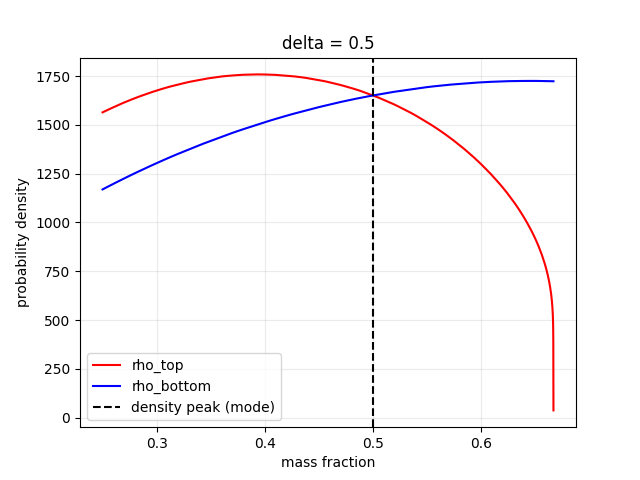

In [15]:
plt.close('density')
fig = plt.figure('density')
ax = fig.subplots()

ax.plot(m, rho_top, 'r-', label='rho_top')
ax.plot(m, rho_bot, 'b-', label='rho_bottom')
ax.axvline(m[peak], c='k', ls='--', label='density peak (mode)')

ax.grid(alpha=.25)
ax.legend()
ax.set_xlabel('mass fraction')
ax.set_ylabel('probability density')
ax.set_title(f'delta = {delta}')

### estimate source threshold:

In [16]:
m_background = 2 * m[peak]
m_signal = 1 - m_background
threshold_guess = np.interp(m_background, cumulative_mass, sorted_data)

m_above = 1 - cumulative_mass
m_symmetric_above = np.interp(2 * data_mode - sorted_data, sorted_data, cumulative_mass, left=0.)
left = np.where(sorted_data < data_mode)
m_symmetric_above[left] = m_background - cumulative_mass[left]
m_signal_above = m_above - m_symmetric_above
purity = m_signal_above / (m_above+1e-30)
purity[-1] = 1

In [17]:
print(f'data_mode = {data_mode}')
print(f'threshold_guess = {threshold_guess}, m_signal = {m_signal}')

data_mode = 6.58009301843598e-07
threshold_guess = 0.004459216036494905, m_signal = 1.894585275286076e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-0.0012467269552871585, 0.008917774063687966)

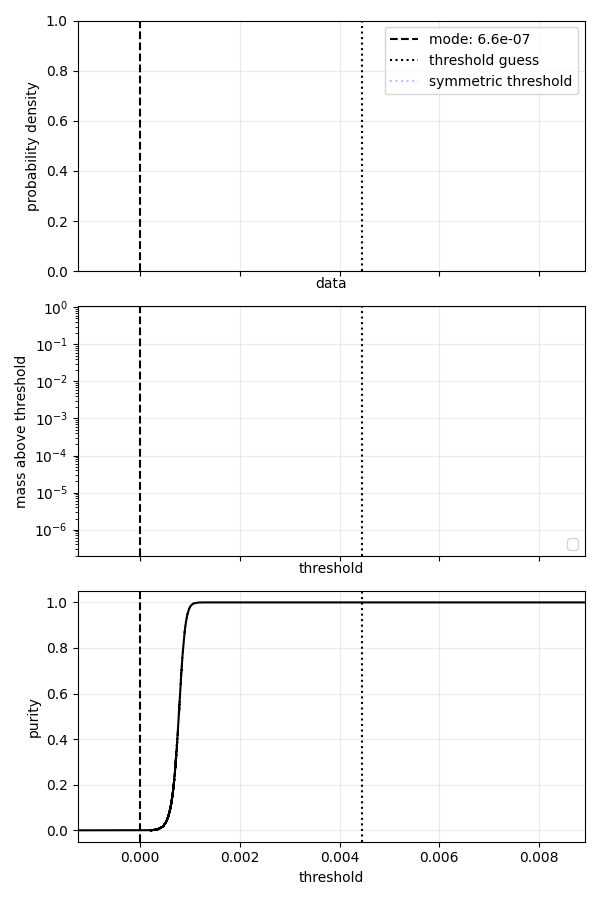

In [18]:
L = max(data_mode-sorted_data[0], threshold_guess-data_mode)

plt.close('statistics')
fig = plt.figure('statistics', figsize=(6, 9))
fig.set_tight_layout(True)
ax = fig.subplots(nrows=3, sharex=True)

# density:

#ax[0].hist(sorted_data, bins=np.linspace(sorted_data[0], data_mode + 5*L, int(np.sqrt(data.size))), alpha=.1)
ax[0].axvline(data_mode, c='k', ls='--', label=f'mode: {data_mode:.2g}')
ax[0].axvline(threshold_guess, c='k', ls=':', label='threshold guess')
ax[0].axvline(2*data_mode-threshold_guess, c='b', ls=':', alpha=.25, label='symmetric threshold')

ax[0].grid(alpha=.25)
ax[0].legend()
ax[0].set_xlabel('data')
ax[0].set_ylabel('probability density')

# mass:

#ax[1].plot(sorted_data, m_above, 'k-', label='total')
#ax[1].plot(sorted_data, m_signal_above, 'r-', label='signal')
#ax[1].plot(sorted_data, m_symmetric_above, 'b-', label='background')
ax[1].axvline(data_mode, c='k', ls='--')
ax[1].axvline(threshold_guess, c='k', ls=':')

ax[1].grid(alpha=.25)
ax[1].legend(loc='lower right')
ax[1].set_xlabel('threshold')
#ax[1].set_xlim(sorted_data[0], data_mode + 5*L)
ax[1].set_ylabel('mass above threshold')
ax[1].set_yscale('log')
ax[1].set_ylim(1e-2*m_signal, 1.1)

# purity:

ax[2].plot(sorted_data, purity, 'k-')
ax[2].axvline(data_mode, c='k', ls='--')
ax[2].axvline(threshold_guess, c='k', ls=':')

ax[2].grid(alpha=.25)
#ax[2].legend()
ax[2].set_xlabel('threshold')
ax[2].set_ylabel('purity')

ax[0].set_xlim(sorted_data[0], data_mode + 2*L)

## 3. Hierarchical Overdensity Tree (HOT)

### routine definition:

In [19]:
@njit
def hot(data, threshold=-np.inf):
    """Hierarchical Overdenity Tree (HOT)"""

    flat_data = data.flatten()
    strides = np.array(data.strides)//data.itemsize

    label = np.zeros(data.size, dtype=np.int64)
    n_labels = 0
    parent = np.zeros(data.size, dtype=np.int64)
    area = np.zeros(data.size, dtype=np.int64)
    max_value = np.zeros_like(flat_data)
    saddle_value = np.full_like(max_value, threshold)
    saddle_area = np.zeros(data.size, dtype=np.int64)

    for pixel in np.argsort(flat_data)[::-1]:  # decreasing order
        pixel_value = flat_data[pixel]
        if np.isnan(pixel_value):
            continue
        if pixel_value < threshold:
            break

        neighbour_parents = []
        for stride in strides:
            if pixel >= stride:
                p = label[pixel-stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)
            if pixel+stride < flat_data.size:
                p = label[pixel+stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            n_labels += 1
            selected_parent = n_labels
            parent[n_labels] = n_labels
            max_value[n_labels] = pixel_value
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                parent[p] = selected_parent
                if saddle_area[p] == 0:
                    saddle_value[p] = pixel_value
                    saddle_area[p] = area[p]+1
            #saddle_area[selected_parent] -= 1

        label[pixel] = selected_parent
        area[selected_parent] += 1
        #saddle_area[selected_parent] += 1
        if saddle_area[selected_parent] == 0:
            saddle_value[selected_parent] = pixel_value
    
    n_src = np.count_nonzero(label)
    indep = np.where(parent[:n_labels+1] == np.arange(n_labels+1))
    print(f'{n_labels} overdensities found:',
          f'{n_src} "pixels" ({int(100*n_src/data.size)}%),',
          f'{indep[0].size -1} independent regions')
    area[0] = saddle_area[0] = data.size-n_src
    saddle_area[indep] = area[indep]
    max_value[0] = saddle_value[0] = threshold
    catalog = (parent[:n_labels+1],
               area[:n_labels+1],
               max_value[:n_labels+1],
               saddle_value[:n_labels+1],
               saddle_area[:n_labels+1],
              )

    return label.reshape(data.shape), catalog


### normal and inverted catalogues:

In [20]:
label, catalog = hot(data-data_mode, 0)
segmentation = segm.SegmentationImage(label)
parent = catalog[0]
area = catalog[1]
max_value = catalog[2]
saddle_value = catalog[3]
saddle_area = catalog[4]

label_inv, catalog_inv = hot(data_mode-data, 0)
segmentation_inv = segm.SegmentationImage(label_inv)
parent_inv = catalog_inv[0]
area_inv = catalog_inv[1]
max_value_inv = catalog_inv[2]
saddle_value_inv = catalog_inv[3]
saddle_area_inv = catalog_inv[4]


632205 overdensities found: 38710734 "pixels" (50%), 3401 independent regions
632668 overdensities found: 38709266 "pixels" (49%), 3462 independent regions


I tried to predict the probability distribution of max_value and saddle value, given saddle_area. In the former, I more or less succeeded...

In [21]:
'''
plot_areas_edges = [2, 3, 4, 6, 10, 20, 50, 100]
x_bg = np.sort(data_mode-data[data < data_mode])
P_bg = (np.arange(x_bg.size)+.5)/x_bg.size

plt.close('selection model')
fig = plt.figure('selection model', figsize=(8, 4+np.sqrt(len(plot_areas_edges))))
ax = fig.subplots(nrows=len(plot_areas_edges)-1, ncols=2, squeeze=False,
                  sharex=True, sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0})
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)


for i in range(len(plot_areas_edges)-1):
    ax[i, 0].set_ylabel('fraction above value')
    ax[i, 0].set_yscale('log')
    
    n0 = plot_areas_edges[i]
    n1 = plot_areas_edges[i+1]
    selected_regions = np.where((saddle_area >= n0) & (saddle_area < n1))
    seleced_max = np.sort(max_value[selected_regions])
    seleced_saddle = np.sort(saddle_value[selected_regions])
    selected_regions_inv = np.where((saddle_area_inv >= n0) & (saddle_area_inv < n1))
    seleced_max_inv = np.sort(max_value_inv[selected_regions_inv])
    seleced_saddle_inv = np.sort(saddle_value_inv[selected_regions_inv])

    f = np.arange(seleced_max.size)[::-1]/seleced_max.size
    ax[i, 0].plot(seleced_max, f, 'b-', label=f'{seleced_max.size} positive')
    f = np.arange(seleced_max_inv.size)[::-1]/seleced_max_inv.size
    ax[i, 0].plot(seleced_max_inv, f, 'r-', label=f'{seleced_max_inv.size} negative')
    ax[i, 0].plot(x_bg, 1-P_bg**n0, 'k-', label=f'saddle area={n0}')
    ax[i, 0].plot(x_bg, 1-P_bg**n1, 'k:', label=f'saddle area={n1}')

    f = np.arange(seleced_saddle.size)[::-1]/seleced_saddle.size
    ax[i, 1].plot(seleced_saddle, f, 'b-', label='positive')
    f = np.arange(seleced_saddle_inv.size)[::-1]/seleced_saddle_inv.size
    ax[i, 1].plot(seleced_saddle_inv, f, 'r-', label='negative')
    ax[i, 1].plot(x_bg, (1-P_bg)**n0, 'k-', label=f'saddle area={n0}')
    ax[i, 1].plot(x_bg, (1-P_bg)**n1, 'k:', label=f'saddle area={n1}')

    ax[i, 0].legend(loc='lower left')
    #ax[i, 0].set_ylim(1/n_regions, 1)

ax[-1, 0].set_xlabel('max value')
ax[-1, 1].set_xlabel('saddle value')
ax[-1, 0].set_xscale('log')
#ax[-1, 0].set_xlim(x_bg[-1]/100, x_bg[-1])
'''

"\nplot_areas_edges = [2, 3, 4, 6, 10, 20, 50, 100]\nx_bg = np.sort(data_mode-data[data < data_mode])\nP_bg = (np.arange(x_bg.size)+.5)/x_bg.size\n\nplt.close('selection model')\nfig = plt.figure('selection model', figsize=(8, 4+np.sqrt(len(plot_areas_edges))))\nax = fig.subplots(nrows=len(plot_areas_edges)-1, ncols=2, squeeze=False,\n                  sharex=True, sharey='row',\n                  gridspec_kw={'hspace': 0, 'wspace': 0})\nfor axis in ax.flatten():\n    axis.tick_params(which='both', direction='in')\n    axis.grid(alpha=.5)\nfig.set_tight_layout(True)\n\n\nfor i in range(len(plot_areas_edges)-1):\n    ax[i, 0].set_ylabel('fraction above value')\n    ax[i, 0].set_yscale('log')\n    \n    n0 = plot_areas_edges[i]\n    n1 = plot_areas_edges[i+1]\n    selected_regions = np.where((saddle_area >= n0) & (saddle_area < n1))\n    seleced_max = np.sort(max_value[selected_regions])\n    seleced_saddle = np.sort(saddle_value[selected_regions])\n    selected_regions_inv = np.where((s

## 4. Object selection

### estimate thresholds:

Compute upper hulls in log(max_value) and log(saddle_value) as a funtion of log(saddle area) for the "inverted" data:

In [22]:
def upper_hull(x, y):
    """Compute upper hull"""
    
    points = np.array([x, y]).T
    hull = ConvexHull(points)
    i_max = np.argmax(x[hull.vertices])
    i_min = np.argmin(x[hull.vertices])
    if i_min > i_max:
        i = hull.vertices[i_max:i_min+1]
    else:
        i = np.concatenate([hull.vertices[i_max:], hull.vertices[:i_min+1]])
    srt = np.argsort(x[i])
    return x[i[srt]], y[i[srt]]


log_sarea_inv = np.log(saddle_area_inv[1:])
log_max_inv = np.log(max_value_inv[1:])
log_svalue_inv = np.log(saddle_value_inv[1:])
max_hull_x, max_hull_y = upper_hull(log_sarea_inv, log_max_inv)
saddle_hull_x, saddle_hull_y = upper_hull(log_sarea_inv, log_svalue_inv)

Let's go for a more aggressive threshold:

In [23]:
log_sarea = np.log(saddle_area)
log_max = np.log(max_value)
log_svalue = np.log(saddle_value)

max_cut = np.interp(log_sarea, max_hull_x, max_hull_y)
max_cut_inv = np.interp(log_sarea_inv, max_hull_x, max_hull_y)
saddle_cut = np.interp(log_sarea, saddle_hull_x, saddle_hull_y)
saddle_cut_inv = np.interp(log_sarea_inv, saddle_hull_x, saddle_hull_y)

cut_bins = np.linspace(0, 1, 101)
cut_mid = (cut_bins[1:] + cut_bins[:-1]) / 2

max_hist, cut_bins = np.histogram(np.exp(log_max-max_cut), bins=cut_bins, density=True)
max_hist_inv, cut_bins = np.histogram(np.exp(log_max_inv-max_cut_inv), bins=cut_bins, density=True)
max_threshold = np.max(cut_mid[max_hist < 3*max_hist_inv])
print(f'select objects above {100*max_threshold:.1f}% of max_value upper hull')

saddle_hist, cut_bins = np.histogram(np.exp(log_svalue-saddle_cut), bins=cut_bins, density=True)
saddle_hist_inv, cut_bins = np.histogram(np.exp(log_svalue_inv-saddle_cut_inv), bins=cut_bins, density=True)
saddle_threshold = np.max(cut_mid[saddle_hist < 3*saddle_hist_inv])
#saddle_threshold = 1
print(f'select objects above {100*saddle_threshold:.1f}% of saddle_value upper hull')


select objects above 99.5% of max_value upper hull
select objects above 99.5% of saddle_value upper hull


/tmp/ipykernel_19555/3953992399.py:2: RuntimeWarning: divide by zero encountered in log
  log_max = np.log(max_value)
/tmp/ipykernel_19555/3953992399.py:3: RuntimeWarning: divide by zero encountered in log
  log_svalue = np.log(saddle_value)


/tmp/ipykernel_19555/210001644.py:24: RuntimeWarning: invalid value encountered in true_divide
  ax[1, 1].plot(cut_mid, np.clip(saddle_hist-saddle_hist_inv, 0, np.inf)/(saddle_hist+saddle_hist_inv), 'k-')


Text(0.5, 0, 'saddle_value / upper hull')

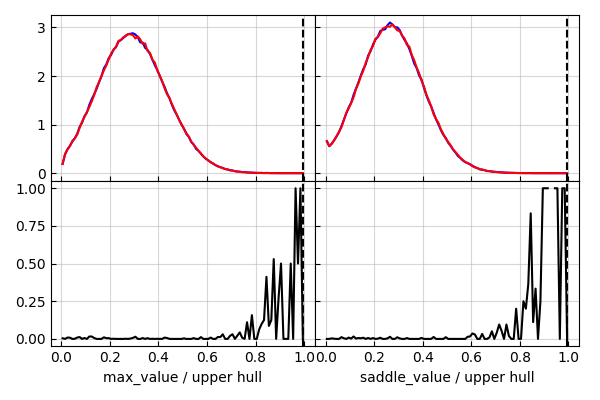

In [24]:
plt.close('cut-based')
fig = plt.figure('cut-based', figsize=(6, 4))
ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                  sharex=True, sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0})
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)


ax[0, 0].plot(cut_mid, max_hist, 'b-')
ax[0, 0].plot(cut_mid, max_hist_inv, 'r-')
ax[0, 0].axvline(max_threshold, c='k', ls='--')

ax[1, 0].plot(cut_mid, np.clip(max_hist-max_hist_inv, 0, np.inf)/(max_hist+max_hist_inv), 'k-')
ax[1, 0].axvline(max_threshold, c='k', ls='--')


ax[0, 1].plot(cut_mid, saddle_hist, 'b-')
ax[0, 1].plot(cut_mid, saddle_hist_inv, 'r-')
ax[0, 1].axvline(saddle_threshold, c='k', ls='--')

ax[1, 1].plot(cut_mid, np.clip(saddle_hist-saddle_hist_inv, 0, np.inf)/(saddle_hist+saddle_hist_inv), 'k-')
ax[1, 1].axvline(saddle_threshold, c='k', ls='--')

ax[1, 0].set_xlabel('max_value / upper hull')
ax[1, 1].set_xlabel('saddle_value / upper hull')

### apply threshod-based selection criteria:

In [25]:
selected = np.where(
    (log_max > np.log(max_threshold) + max_cut)
    |
    (log_svalue > np.log(saddle_threshold) + saddle_cut)
)
print(f'{selected[0].size} overdensities pass the selection criteria')

valid_labels = -np.arange(parent.size)
valid_labels[selected] = 0
valid_labels += np.arange(parent.size)
valid_labels = valid_labels[label]
thresold_selection = segm.SegmentationImage(valid_labels)

80 overdensities pass the selection criteria


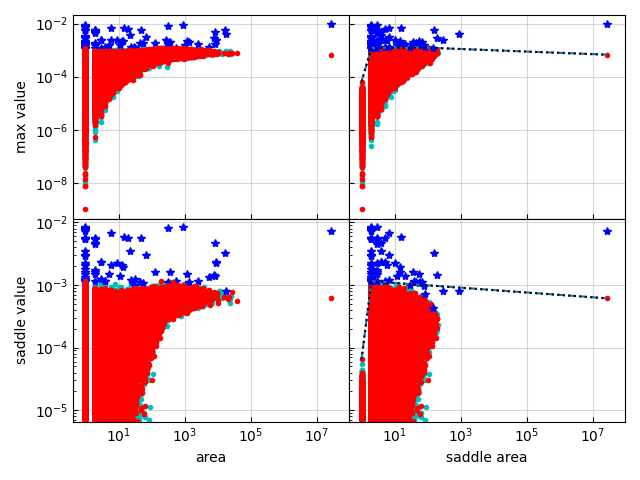

In [26]:
plt.close('selection')
fig = plt.figure('selection')
ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                  sharex=True, sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0})
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)

ax[0, 0].set_ylabel('max value')
ax[0, 0].set_yscale('log')
ax[0, 0].plot(catalog[1], catalog[2], 'c.')
ax[0, 0].plot(catalog[1][selected], catalog[2][selected], 'b*')
ax[0, 0].plot(catalog_inv[1], catalog_inv[2], 'r.')

ax[1, 0].set_ylabel('saddle value')
ax[1, 0].set_yscale('log')
ax[1, 0].plot(catalog[1], catalog[3], 'c.')
ax[1, 0].plot(catalog[1][selected], catalog[3][selected], 'b*')
ax[1, 0].plot(catalog_inv[1], catalog_inv[3], 'r.')

ax[-1, 0].set_xlabel('area')
ax[-1, 0].set_xscale('log')


ax[0, 1].plot(catalog[4], catalog[2], 'c.')
ax[0, 1].plot(catalog_inv[4], catalog_inv[2], 'r.')
ax[0, 1].plot(catalog[4][selected], catalog[2][selected], 'b*')
ax[0, 1].plot(np.exp(max_hull_x), np.exp(max_hull_y), '--')
ax[0, 1].plot(np.exp(max_hull_x), max_threshold*np.exp(max_hull_y), 'k:')

ax[1, 1].plot(catalog[4], catalog[3], 'c.')
ax[1, 1].plot(catalog_inv[4], catalog_inv[3], 'r.')
ax[1, 1].plot(catalog[4][selected], catalog[3][selected], 'b*')
#ax[1, 1].plot(nn, cut_saddle, 'k--')
ax[1, 1].plot(np.exp(saddle_hull_x), np.exp(saddle_hull_y), '--')
ax[1, 1].plot(np.exp(saddle_hull_x), saddle_threshold*np.exp(saddle_hull_y), 'k:')
ax[1, 1].set_ylim(.1*saddle_threshold*np.exp(np.min(saddle_hull_y)), 10*np.exp(np.max(saddle_hull_y)))

ax[-1, 1].set_xlabel('saddle area')
ax[-1, 1].set_xscale('log')

In [28]:
if data_dimensionality == 2:
    plt.close('HOT')
    fig = plt.figure('HOT', figsize=(9.5, 6))
    fig.set_tight_layout(True)
    ax = fig.subplots(nrows=2, ncols=3, sharex=True, sharey=True)
    delta = threshold_guess-data_mode

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data-data_mode,
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=-delta, linthresh=3*delta, vmax=np.max(data-data_mode)),
        )
    cb = fig.colorbar(im, ax=ax[0, 0])

    ax[0, 1].set_title(f'Parent map\n({parent.size} candidates)')
    im = ax[0, 1].imshow(
        segmentation,
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])

    ax[0, 2].set_title(f'Threshold selection\n({selected[0].size} objects)')
    im = ax[0, 2].imshow(
        thresold_selection,
        interpolation='nearest', origin='lower', cmap=thresold_selection.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 2])

    ax[1, 0].set_title('Max value')
    im = ax[1, 0].imshow(
        max_value[label],
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=-delta, linthresh=3*delta, vmax=np.max(data-data_mode)),
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    ax[1, 1].set_title('Saddle value')
    im = ax[1, 1].imshow(
        saddle_value[label],
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=-delta, linthresh=3*delta, vmax=np.max(data-data_mode)),
        )
    cb = fig.colorbar(im, ax=ax[1, 1])

    ax[1, 2].set_title('Saddle area')
    im = ax[1, 2].imshow(
        saddle_area[label],
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm=colors.LogNorm(),
        )
    cb = fig.colorbar(im, ax=ax[1, 2])


## 5. Mode filter

In [29]:
@njit
def mode_filter(data):
    flat_data = data.flatten()
    mode = np.empty_like(flat_data)
    count = np.empty_like(flat_data)
    strides = np.array(data.strides)//data.itemsize
    neighbours = np.empty(2*len(strides)+1, dtype=np.int64)
    counts = np.empty_like(neighbours)
    n_changes = 0
    
    for pixel in range(flat_data.size):
        #print('>', pixel)
        neighbours[0] = flat_data[pixel]
        counts[0] = 1
        n_neighbours = 1
        for stride in strides:
            if pixel >= stride:
                #print(-stride)
                value = flat_data[pixel-stride]
                n = 0
                while True:
                    if value == neighbours[n]:
                        counts[n] += 1
                        break
                    else:
                        n += 1
                        if n == n_neighbours:
                            neighbours[n] = value
                            counts[n] = 1
                            n_neighbours += 1
                            break
            if pixel+stride < flat_data.size:
                value = flat_data[pixel+stride]
                #print(stride, value)
                n = 0
                while True:
                    if value == neighbours[n]:
                        counts[n] += 1
                        break
                    else:
                        n += 1
                        if n == n_neighbours:
                            neighbours[n] = value
                            counts[n] = 1
                            n_neighbours += 1
                            break
        best = np.argmax(counts[:n_neighbours])
        if counts[best] == counts[0]: # just in case
            best = 0
        else:
            n_changes += 1
        #print(f'> pixel {pixel} moves from {neighbours[0]} to {neighbours[best]} (out of {n_neighbours} possibilities)')
        mode[pixel] = neighbours[best]
        count[pixel] = counts[best]
        
    return mode.reshape(data.shape), count.reshape(data.shape), n_changes


In [30]:
filtered_labels = np.copy(valid_labels)
n_old = 0
n = filtered_labels.size
while n != n_old:
    n_old = n
    filtered_labels, c, n = mode_filter(filtered_labels)
    print(n, 'changes')

6026007 changes
2840720 changes
1421914 changes
770350 changes
453751 changes
287515 changes
189389 changes
128998 changes
89822 changes
63978 changes
46898 changes
35209 changes
27180 changes
21777 changes
17978 changes
15379 changes
13648 changes
12383 changes
11528 changes
10945 changes
10518 changes
10242 changes
10029 changes
9886 changes
9786 changes
9691 changes
9625 changes
9585 changes
9554 changes
9535 changes
9522 changes
9511 changes
9504 changes
9503 changes
9503 changes


In [31]:
final_labels = np.copy(filtered_labels)
unique_labels = np.unique(filtered_labels)
n_final_labels = unique_labels.size
print(f'{n_final_labels} objects after mode filtering')

for i, lbl in enumerate(unique_labels):
    final_labels[final_labels == lbl] = i
final_selection = segm.SegmentationImage(final_labels)

35 objects after mode filtering


In [32]:
if data_dimensionality == 2:
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 5))
    ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data-data_mode,
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=-delta, linthresh=3*delta, vmax=np.max(data-data_mode)),
        )
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')

    ax[0, 1].set_title(f'Final selection map\n({n_final_labels} objects)')
    im = ax[0, 1].imshow(
        final_selection,
        interpolation='nearest', origin='lower', cmap=final_selection.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])


/tmp/ipykernel_19555/2520761016.py:35: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),


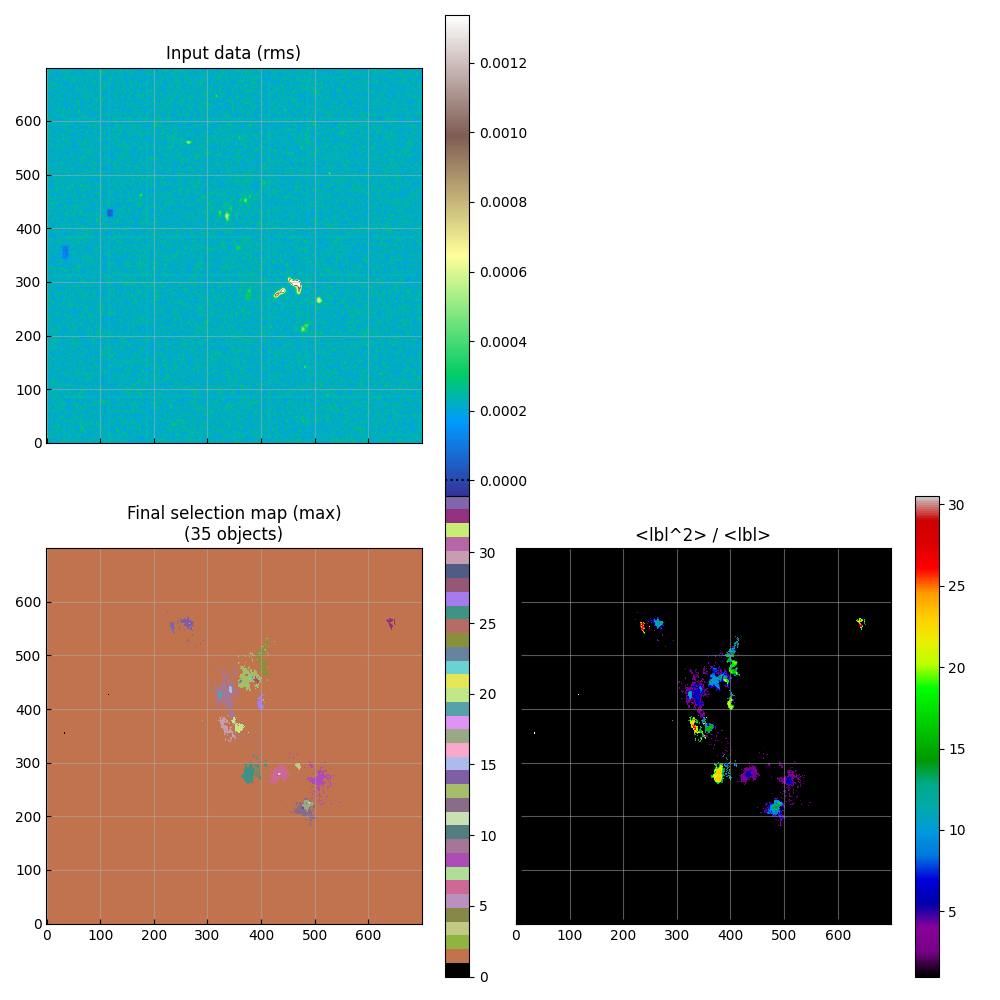

In [54]:
if data_dimensionality == 3:
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (rms)')
    im = ax[0, 0].imshow(
        np.sqrt(np.nanmean((data-data_mode)**2, axis=0)),
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta, linthresh=3*delta, vmax=np.max(data-data_mode)),
        vmin=-delta/100, vmax=3*delta/10,
        )
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    
    ax[0, 1].axis('off')

    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_final_labels} objects)')
    im = ax[1, 0].imshow(
        np.nanmax(final_selection, axis=0),
        interpolation='nearest', origin='lower', cmap=final_selection.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        )
    cb = fig.colorbar(im, ax=ax[1, 1])
